In [50]:

import xarray as xr
from glob import glob
import pylab as plt
import pandas as pd
import os
from functools import reduce
import seaborn as sns

from pismragis.analysis import sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_paleo_file, copy_file
from pismragis.stats import run_stats

In [3]:
data_dir = "/import/c1/ICESHEET/ICESHEET/pism-greenland/paleo/"

grid = 12000
exp = {"Experiment": "climate-calving",
        "proj_dir": "2023_10_climate_calving_w_posterior/",
        "scalar_dir": "scalar",
        "processed_dir": "processed_scalar",
        "fig_dir": "figures",
        "lhs": "gris_paleo_climate_calving_w_posterior_lhs_20",
        "DEM": "GRIMP"
    }

s_dir = os.path.join(data_dir, exp["proj_dir"], exp["scalar_dir"])
fig_dir = os.path.join(data_dir, exp["proj_dir"], exp["fig_dir"])
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

scalar_files = sorted(glob(os.path.join(s_dir, f"""ts_gris_ext_g{grid}m_*{exp["DEM"]}_id_*.nc""")))
processed_path = os.path.join(data_dir, exp["proj_dir"], exp["processed_dir"])
for scalar_file in scalar_files:
    if check_paleo_file:
        copy_file(scalar_file, processed_path)
processed_files = sorted(glob(os.path.join(processed_path, f"""ts_gris_ext_g{grid}m_*{exp["DEM"]}_id_*.nc""")))



In [ ]:
ds = xr.open_mfdataset(processed_files, combine="nested", concat_dim="id", parallel=True)

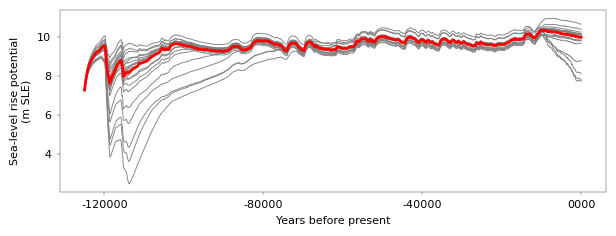

In [4]:
fontsize = 8
lw = 0.65
markersize = 1
params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
    }

plt.rcParams.update(params)

plot_var = "sea_level_rise_potential" 

fig = plt.figure(figsize=[6.2, 2.4])
ax = fig.add_subplot(111)
ds[plot_var].plot.line(x="time", color="0.5", ax=ax, add_legend=False)
ds[plot_var].median(dim="id").plot.line(x="time", color="r", lw=2, ax=ax, label="median", add_legend=True)
ax.set_ylabel("Sea-level rise potential\n(m SLE)")
ax.set_xlabel("Years before present")
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, f"{plot_var}_paleo-ensemble-{grid}m.pdf"))

In [5]:


# with xr.open_mfdataset(processed_files, combine="nested", concat_dim="id", join="inner", parallel=True) as ds:
#     print(ds)
    
ens = ds["sea_level_rise_potential"].resample(time="100AS").mean()
ens_df = ens.to_dataframe().reset_index().dropna()


In [6]:
uq_file = "../uncertainty_quantification/gris_paleo_climate-calving_w_posterior_lhs_20.csv"
uq_df = pd.read_csv(uq_file)

In [7]:
sa_df = sensitivity_analysis(ens_df, ensemble_file=uq_file, n_jobs=40, calc_variables=["sea_level_rise_potential"])

-------------------------------------------



Processing date: 100%|██████████| 1251/1251 [00:53<00:00, 23.26it/s]


Program finished in 54 seconds


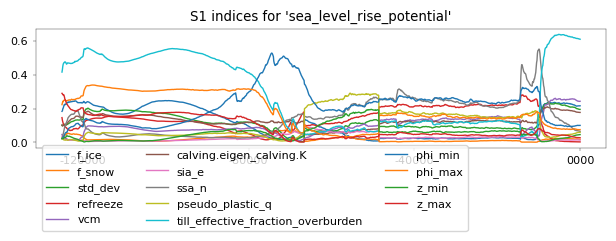

In [8]:
    si = "S1"
    outfile = f"""{si}_paleo_{grid}m.pdf"""
    fig, ax = plt.subplots(
        1,
        1,
        sharex="col",
        figsize=[6.2, 4.6],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["sea_level_rise_potential"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        # [
        #     ax.fill_between(
        #         ds.time,
        #         p_df[v].values - p_conf_df[v].values,
        #         p_df[v].values + p_conf_df[v].values,
        #         alpha=0.2,
        #         lw=0,
        #     )
        #     for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        # ]
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = ax.legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    fig.savefig(os.path.join(fig_dir, outfile))


/home/aaschwanden/miniconda3/envs/pism-processing/lib/python3.11/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


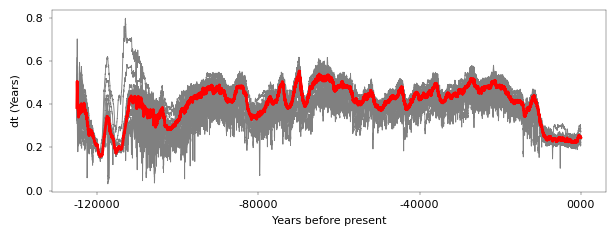

In [9]:
plot_var = "dt"
runmean_100a_ds = ds.rolling(time=100, center=True).mean()

fig = plt.figure(figsize=[6.2, 2.4])
ax = fig.add_subplot(111)
runmean_100a_ds["dt"].plot.line(x="time", color="0.5", ax=ax, add_legend=False)
runmean_100a_ds["dt"].median(dim="id").plot.line(x="time", color="r", lw=2, ax=ax, label="median", add_legend=True)
ax.set_ylabel("dt (Years)")
ax.set_xlabel("Years before present")
fig.tight_layout()
fig.savefig(f"{plot_var}_paleo-ensemble-12km.pdf")

In [10]:
process_groups = {"Surface": ["f_ice", "f_snow", "std_dev", "refreeze"],
                 "Calving": ["vcm", "calving.eigen_calving.K"],
                 "Ice Flow": ["sia_e", "ssa_n", "pseudo_plastic_q", "till_effective_fraction_overburden", "phi_min", "phi_max", "z_min", "z_max"]
                 }

In [11]:
sa_by_process_dfs = [pd.merge(sa_df[process_groups[p]].sum(axis=1).rename(p), sa_df[["Date", "Si", "Variable"]], left_index=True, right_index=True) for p in process_groups.keys()]

In [12]:
sa_by_process_df = reduce(lambda  left,right: pd.merge(left,right,on=["Date", "Si", "Variable"]), sa_by_process_dfs)

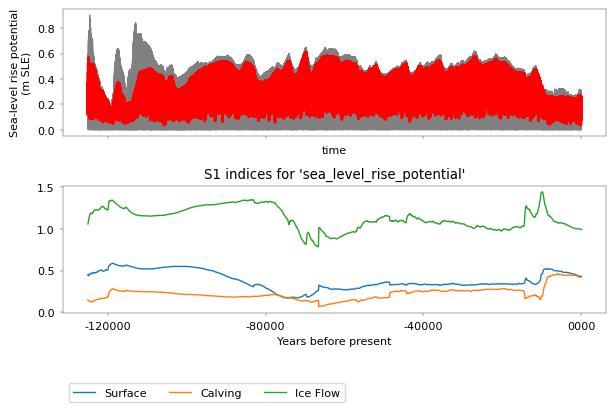

In [13]:
    si = "S1"
    outfile = f"""{si}_by_process_paleo_{grid}m.pdf"""
    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[6.2, 4.6],
    )
    fig.subplots_adjust(bottom=0.0)
    ax = axs[0]
    ds[plot_var].plot.line(x="time", color="0.5", ax=ax, add_legend=False)
    ds[plot_var].median(dim="id").plot.line(x="time", color="r", lw=2, ax=ax, label="median", add_legend=True)
    ax.set_ylabel("Sea-level rise potential\n(m SLE)")

    ax = axs[1]
    for k, m_var in enumerate(["sea_level_rise_potential"]):
        m_df = sa_by_process_df[sa_df["Variable"] == m_var]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_by_process_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = ax.legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    ax.set_xlabel("Years before present")
    fig.tight_layout()
    fig.savefig(os.path.join(fig_dir, outfile))


In [52]:
def merge_by_process(df: pd.DataFrame, process_groups: dict, p: str) -> pd.DataFrame:
    m_df = pd.merge(df[process_groups[p]].sum(axis=1).rename("Si_value"), sa_df[["Date", "Si", "Variable"]], left_index=True, right_index=True)
    m_df["Process"] = p
    return m_df

def to_year(cf_datetime):
    return cf_datetime.year

In [62]:
s = pd.concat([merge_by_process(sa_df, process_groups, p) for p in process_groups.keys()]).reset_index(drop=True)
s["time"] = s["Date"].apply(to_year)
m_df = s[s["Si"] == "S1"]
print(m_df)

       Si_value                    Date  Si                  Variable  \
2      0.450605  -124999-01-01 00:00:00  S1  sea_level_rise_potential   
6      0.436350  -124899-01-01 00:00:00  S1  sea_level_rise_potential   
10     0.442069  -124799-01-01 00:00:00  S1  sea_level_rise_potential   
14     0.442299  -124699-01-01 00:00:00  S1  sea_level_rise_potential   
18     0.451541  -124599-01-01 00:00:00  S1  sea_level_rise_potential   
...         ...                     ...  ..                       ...   
14994  0.996893    -0399-01-01 00:00:00  S1  sea_level_rise_potential   
14998  0.995627    -0299-01-01 00:00:00  S1  sea_level_rise_potential   
15002  0.995165    -0199-01-01 00:00:00  S1  sea_level_rise_potential   
15006  0.993904    -0099-01-01 00:00:00  S1  sea_level_rise_potential   
15010  0.992978     0001-01-01 00:00:00  S1  sea_level_rise_potential   

        Process    time  
2       Surface -124999  
6       Surface -124899  
10      Surface -124799  
14      Surface -12

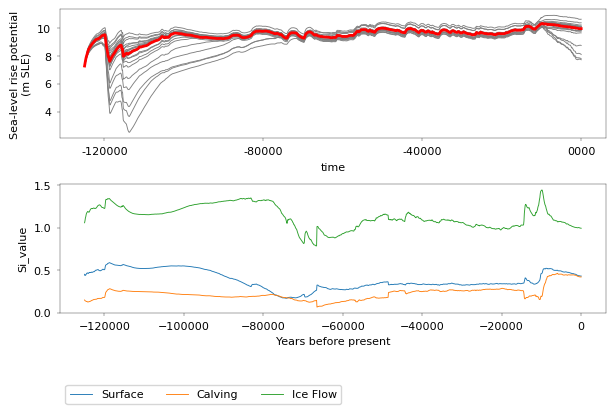

In [74]:
    plot_var = "sea_level_rise_potential"
    si = "S1"
    outfile = f"""{si}_by_process_paleo_{grid}m.pdf"""
    fig, axs = plt.subplots(
        2,
        1,
        figsize=[6.2, 4.6],
    )
    fig.subplots_adjust(bottom=0.0)
    ax = axs[0]
    ds[plot_var].plot.line(x="time", color="0.5", ax=ax, add_legend=False)
    ds[plot_var].median(dim="id").plot.line(x="time", color="r", lw=2, ax=ax, label="median", add_legend=True)
    ax.set_ylabel("Sea-level rise potential\n(m SLE)")

    ax = axs[1]
    sns.lineplot(data=m_df, x="time", y="Si_value", hue="Process", ax=ax)
    legend = ax.legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    ax.set_xlabel("Years before present")
    fig.tight_layout()
    fig.savefig(os.path.join(fig_dir, outfile))



In [67]:
m_df["time"]

2       -124999
6       -124899
10      -124799
14      -124699
18      -124599
          ...  
14994      -399
14998      -299
15002      -199
15006       -99
15010         1
Name: time, Length: 3753, dtype: int64

In [69]:
sns.lineplot?

Signature:
sns.lineplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    size=None,
    style=None,
    units=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    sizes=None,
    size_order=None,
    size_norm=None,
    dashes=True,
    markers=None,
    style_order=None,
    estimator='mean',
    errorbar=('ci', 95),
    n_boot=1000,
    seed=None,
    orient='x',
    sort=True,
    err_style='band',
    err_kws=None,
    legend='auto',
    ci='deprecated',
    ax=None,
    **kwargs,
)
Docstring:
Draw a line plot with possibility of several semantic groupings.

The relationship between `x` and `y` can be shown for different subsets
of the data using the `hue`, `size`, and `style` parameters. These
parameters control what visual semantics are used to identify the different
subsets. It is possible to show up to three dimensions independently by
using all three semantic types, but this style of plot can be hard to
interpret and is often ineffective. Using re

In [46]:
s["Date"].year

AttributeError: 'Series' object has no attribute 'year'

In [49]:
s

,Si_value,Date,Si,Variable,Process,time
0,0.315167,-124999-01-01 00:00:00,delta,sea_level_rise_potential,Surface,-124999
1,0.488118,-124999-01-01 00:00:00,delta_conf,sea_level_rise_potential,Surface,-124999
2,0.450605,-124999-01-01 00:00:00,S1,sea_level_rise_potential,Surface,-124999
3,1.115361,-124999-01-01 00:00:00,S1_conf,sea_level_rise_potential,Surface,-124999
4,0.307573,-124899-01-01 00:00:00,delta,sea_level_rise_potential,Surface,-124899
...,...,...,...,...,...,...
15007,2.249953,-0099-01-01 00:00:00,S1_conf,sea_level_rise_potential,Ice Flow,-99
15008,0.206839,0001-01-01 00:00:00,delta,sea_level_rise_potential,Ice Flow,1
15009,1.505856,0001-01-01 00:00:00,delta_conf,sea_level_rise_potential,Ice Flow,1
15010,0.992978,0001-01-01 00:00:00,S1,sea_level_rise_potential,Ice Flow,1
